In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Masking 
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  300000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'carteta', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 2.2737367544323206e-13


# Crop events to be inbetween 80 and 200 GeV for th_pt

In [3]:
th_pt = np.array(dataset.get('th_pt')[0:crop0])
crop_pt = ((th_pt<80) + (th_pt>200))/2 # less than 80 or greater than 200
crop_pos = np.argwhere(crop_pt)
X_total = np.delete(X_total, crop_pos, axis=0)
Y_total = np.delete(Y_total, crop_pos, axis=0)
exist_orig = Scaler.exist_dict 
Scaler.exist_dict = {key: np.delete(exist_orig[key], crop_pos) for key in exist_orig.keys()}

In [4]:
# Create X and test array
split = int(np.floor(0.8*X_total.shape[0])) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,False)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(131308, 6, 5) (131308, 6) (131308, 9)
(32828, 6, 5) (32828, 6) (32828, 9)


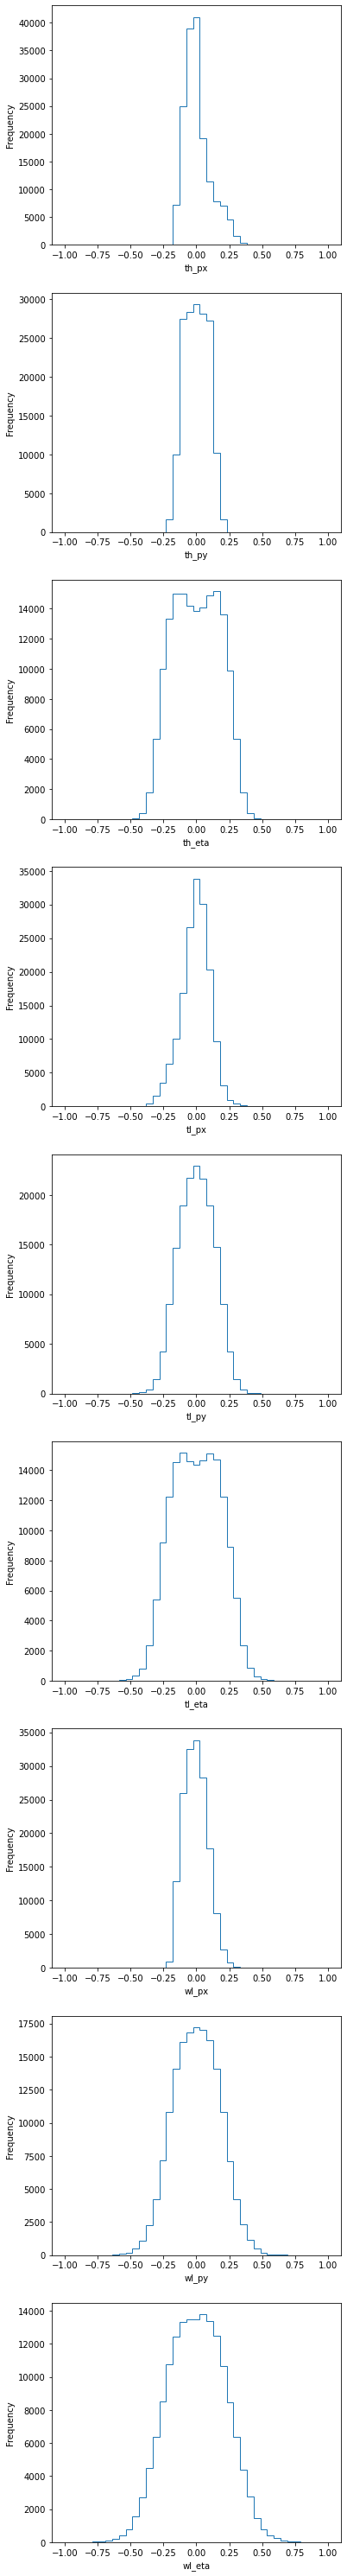

In [5]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [6]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [7]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Conv11 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Mask)
    Conv12 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Conv11)
    flat_jets = Flatten()(Conv11)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(64, activation='relu')(other_input)
    Dense22 = Dense(32, activation='relu')(Dense21)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(256, activation='relu')(concat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=1e-6)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 6, 5)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           448         input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 1000

del X_total
del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 105046 samples, validate on 26262 samples
Epoch 1/1000
105046/105046 [==============================] - 3s 33us/sample - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0574 - val_mse: 0.0574
Epoch 2/1000
105046/105046 [==============================] - 1s 12us/sample - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 3/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 4/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 5/1000
105046/105046 [==============================] - 1s 12us/sample - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 6/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/1000
105046/105046 [==============================] - 1s 12us/sample - loss: 0.0319

105046/105046 [==============================] - 1s 11us/sample - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 58/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 59/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 60/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 61/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 62/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 63/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 

Epoch 114/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 115/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 116/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 117/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 118/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 119/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 120/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0106 - v

105046/105046 [==============================] - 1s 12us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 171/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 172/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 173/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 174/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 175/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 176/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0090 - val_mse: 0.0090


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 227/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 228/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 229/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 230/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 231/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 232/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0083 - val_mse: 0.0083


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 283/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 284/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 285/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 286/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 287/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 288/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0079 - val_mse: 0.0079


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 339/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 340/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 341/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 342/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 343/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 344/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 395/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 396/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 397/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 398/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 399/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 400/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0075 - val_mse: 0.0075


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 451/1000
105046/105046 [==============================] - 1s 10us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 452/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 453/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 454/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 455/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 456/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0073 - val_mse: 0.0073


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 507/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 508/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 509/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 510/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 511/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 512/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0072 - val_mse: 0.0072


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 563/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 564/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 565/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 566/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 567/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 568/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0071 - val_mse: 0.0071


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 619/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 620/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 621/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 622/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 623/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 624/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0069 - val_mse: 0.0069


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 675/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 676/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 677/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 678/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 679/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 680/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 731/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 732/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 733/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 734/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 735/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 736/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0068 - val_mse: 0.0068


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 787/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 788/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 789/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 790/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 791/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 792/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0067 - val_mse: 0.0067


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 843/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 844/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 845/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 846/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 847/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 848/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0066 - val_mse: 0.0066


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 899/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 900/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 901/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 902/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 903/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 904/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065


105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 955/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 956/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 957/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 958/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 959/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 960/1000
105046/105046 [==============================] - 1s 11us/sample - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0065 - val_mse: 0.0065


Text(0.5, 1.0, 'MSE loss')

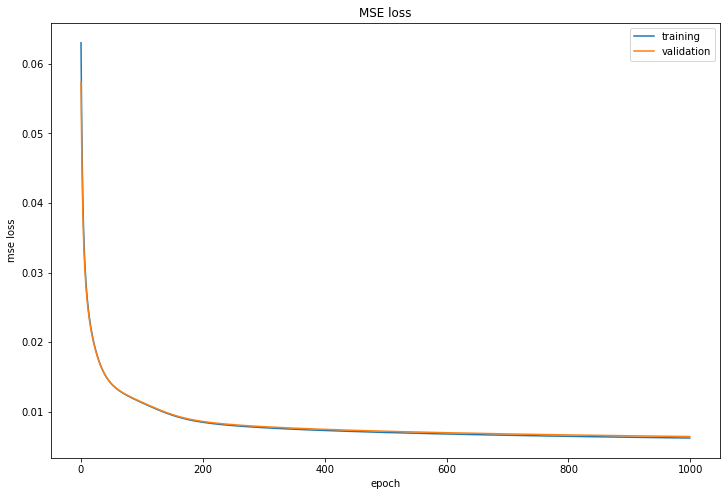

In [9]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [10]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi, bins):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
            plt.hist(diff, hbins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi, bins): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
                
            plt.hist(true_small, hbins, histtype='step', color='b', label='true values', density=False)
            plt.hist(compare_small, hbins, histtype='step', color='r', label='predictions', density=False)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [15]:
from importlib import reload  
from transform import Transform 
reload(scale_variables)

import scale_variables
import shape_timesteps

In [16]:
from importlib import reload  
display = Analysis()
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
lep_phi = np.delete(lep_phi, crop_pos)

Scaler1 = scale_variables.Scale_variables()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler1.scale_arrays(Y_keys, Y_methods, True)

Y_total = np.delete(Y_total, crop_pos, axis=0)
exist_orig = Scaler1.exist_dict 
Scaler1.exist_dict = {key: np.delete(exist_orig[key], crop_pos) for key in exist_orig.keys()}

predictions_origscale = Scaler1.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler1.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)
(164136,)


# Training scale plots 

In [17]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0064215951368127334
 
th_px MSE :  0.0065733638
th_py MSE :  0.0052797556
th_eta MSE :  0.0060840039
tl_px MSE :  0.0055617840
tl_py MSE :  0.0087974048
tl_eta MSE :  0.0062705654
wl_px MSE :  0.0018774153
wl_py MSE :  0.0088435784
wl_eta MSE :  0.0085064849


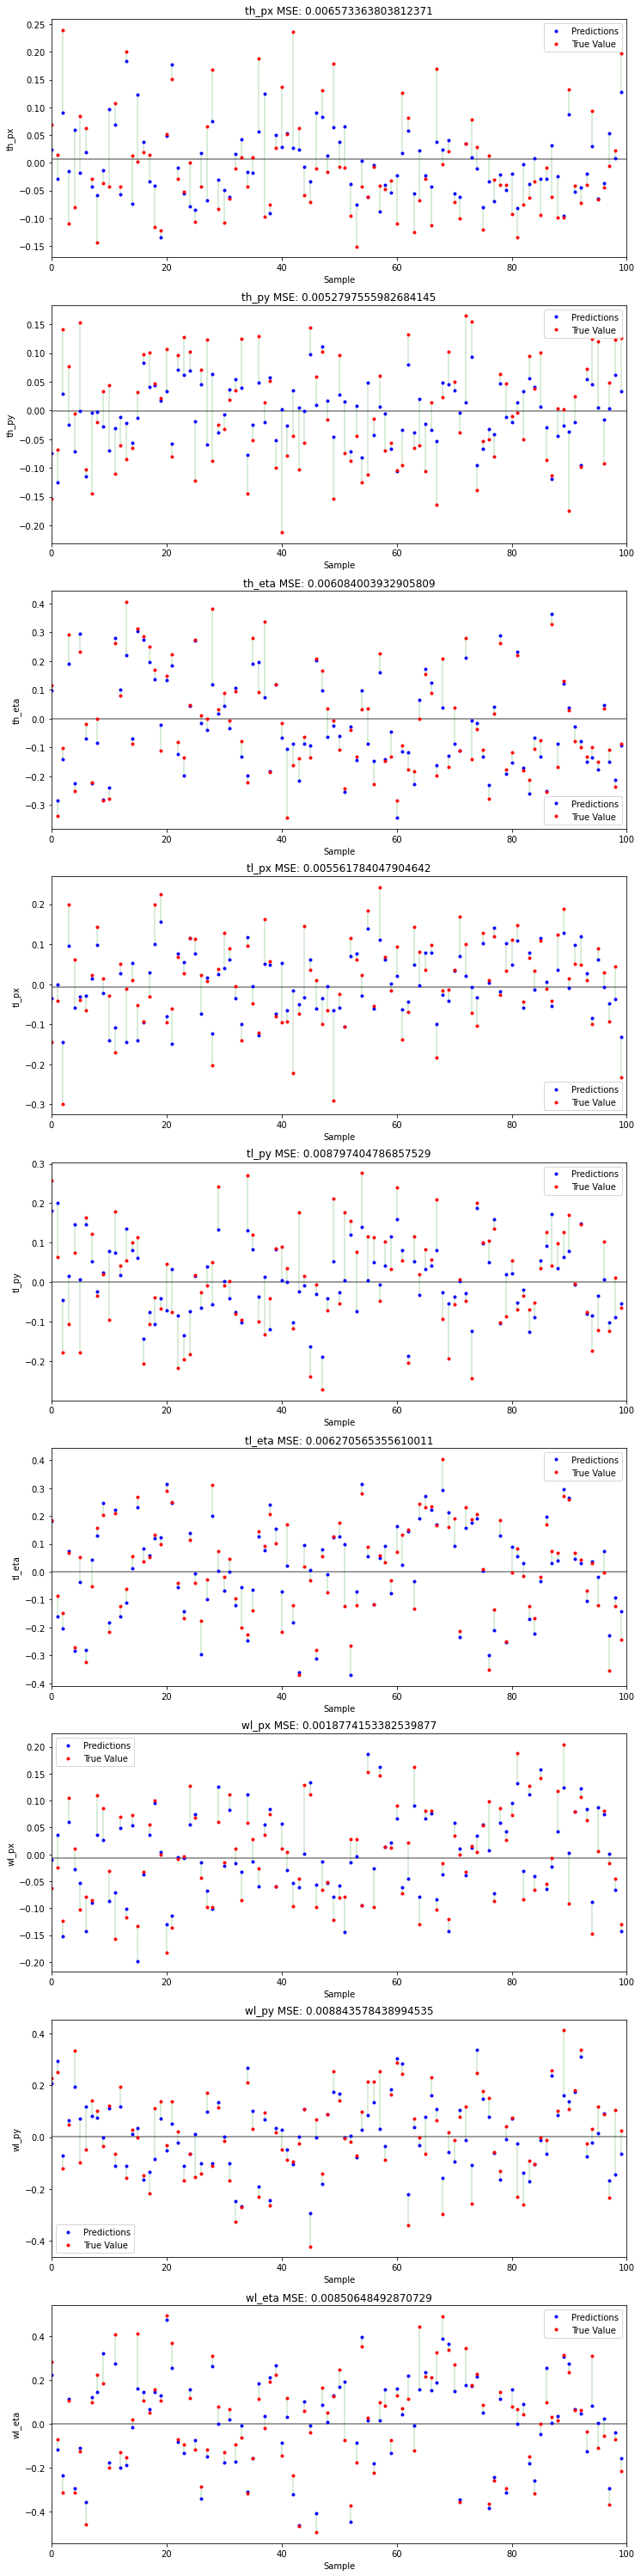

In [18]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

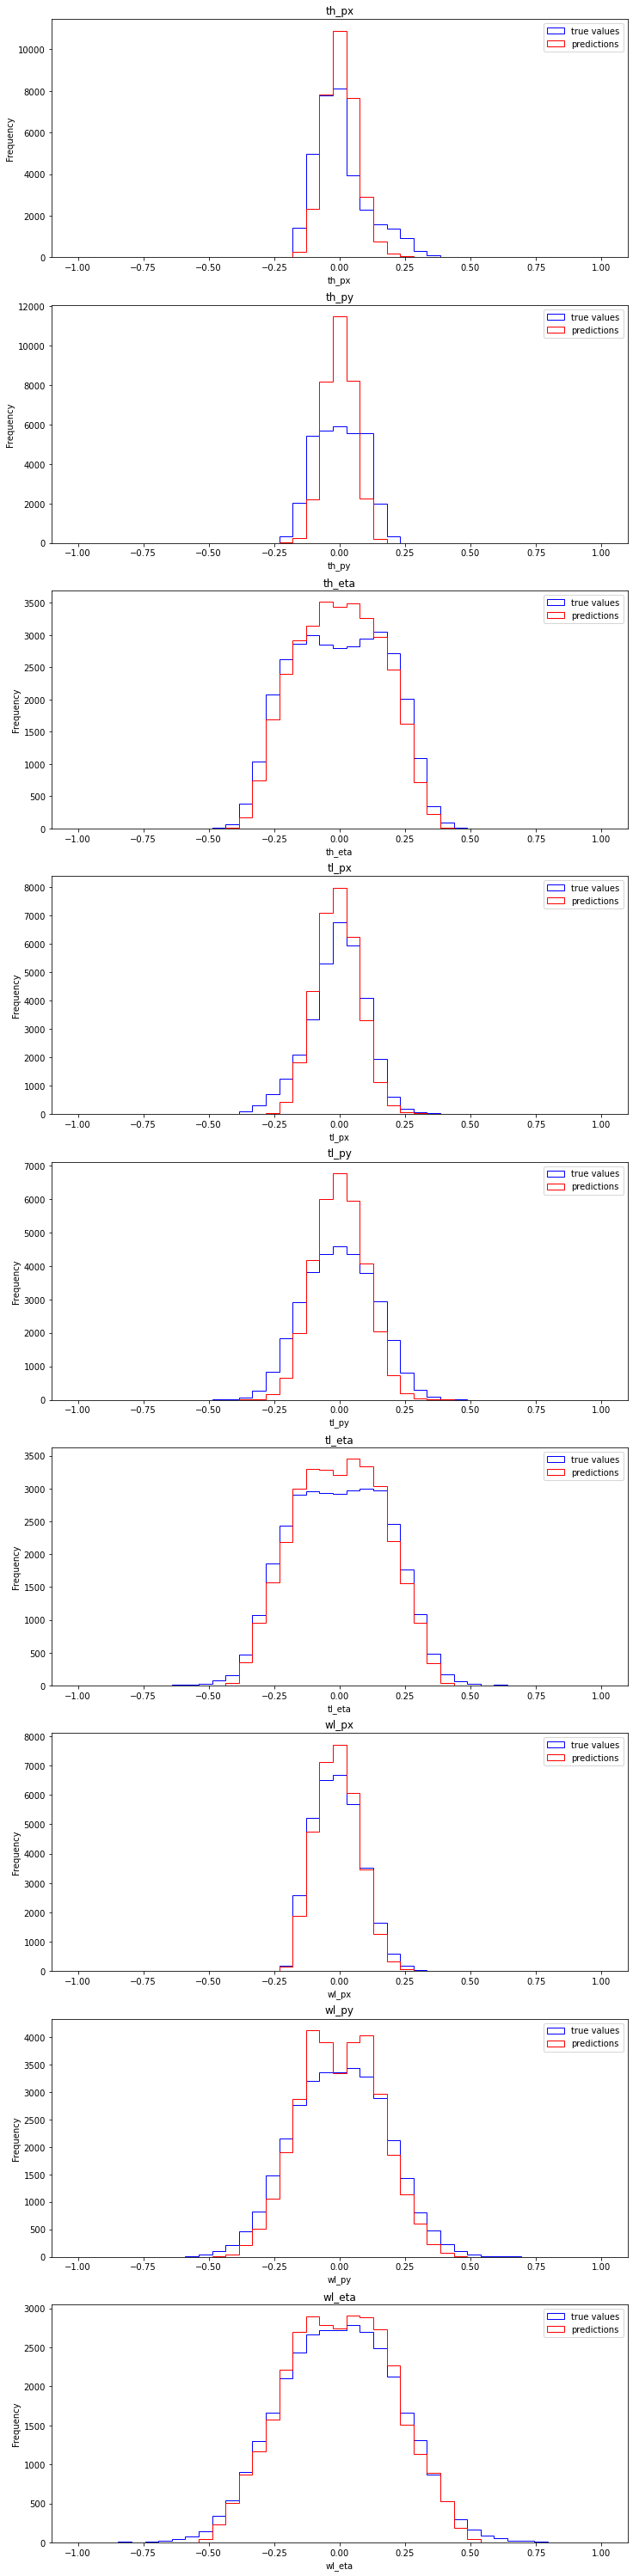

In [19]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

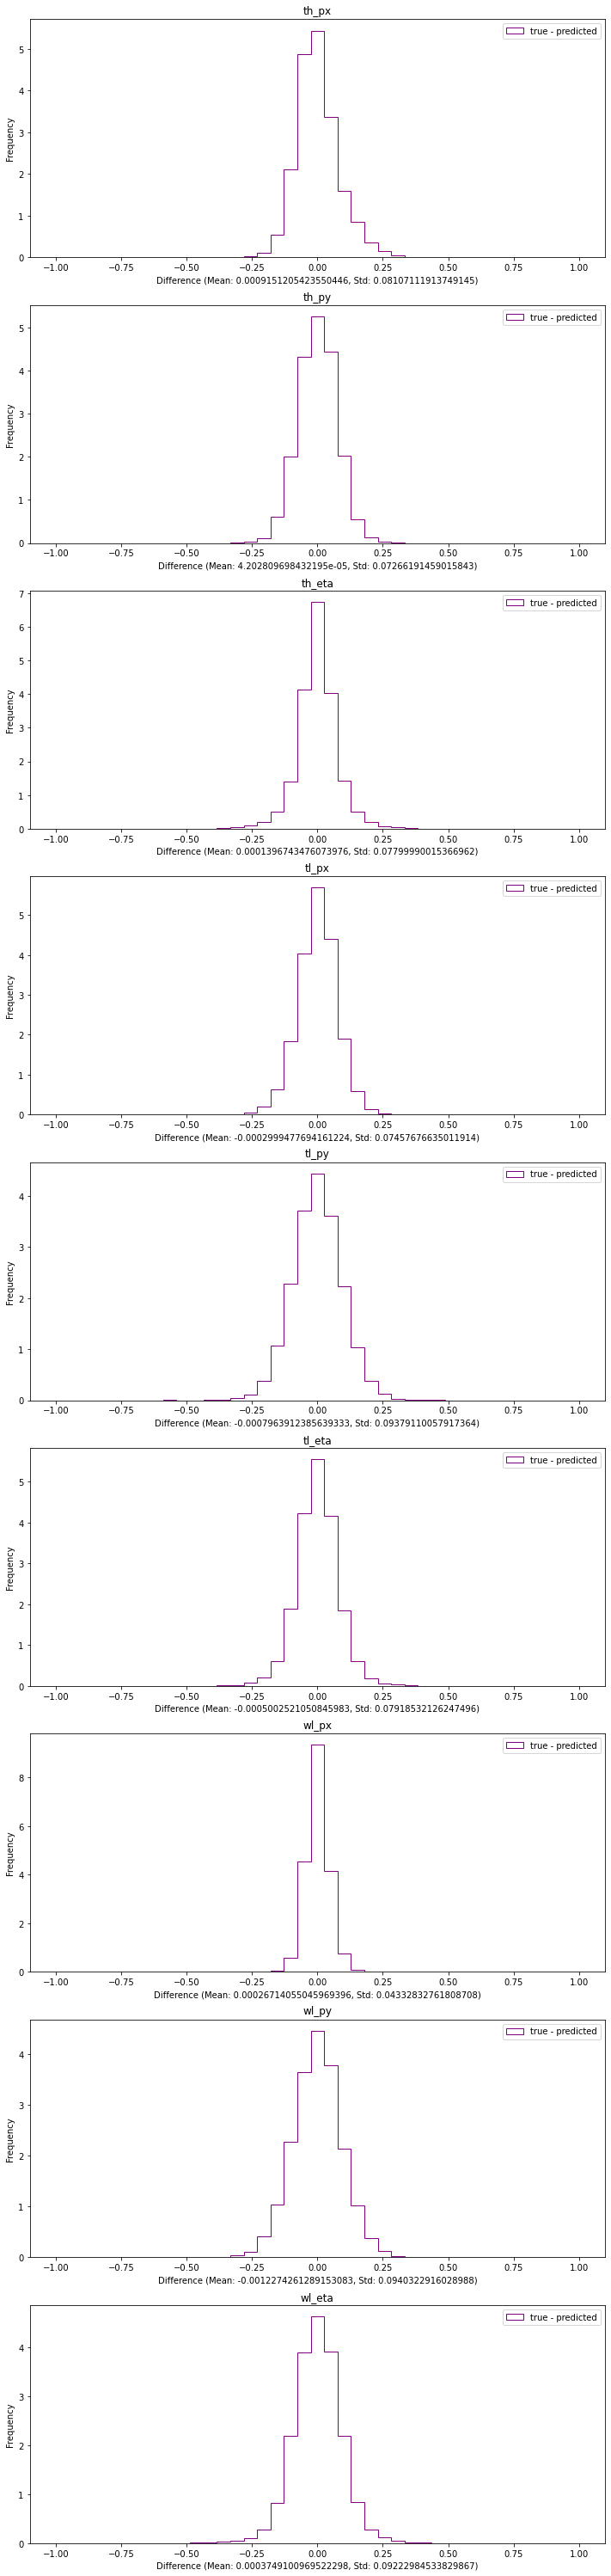

In [20]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

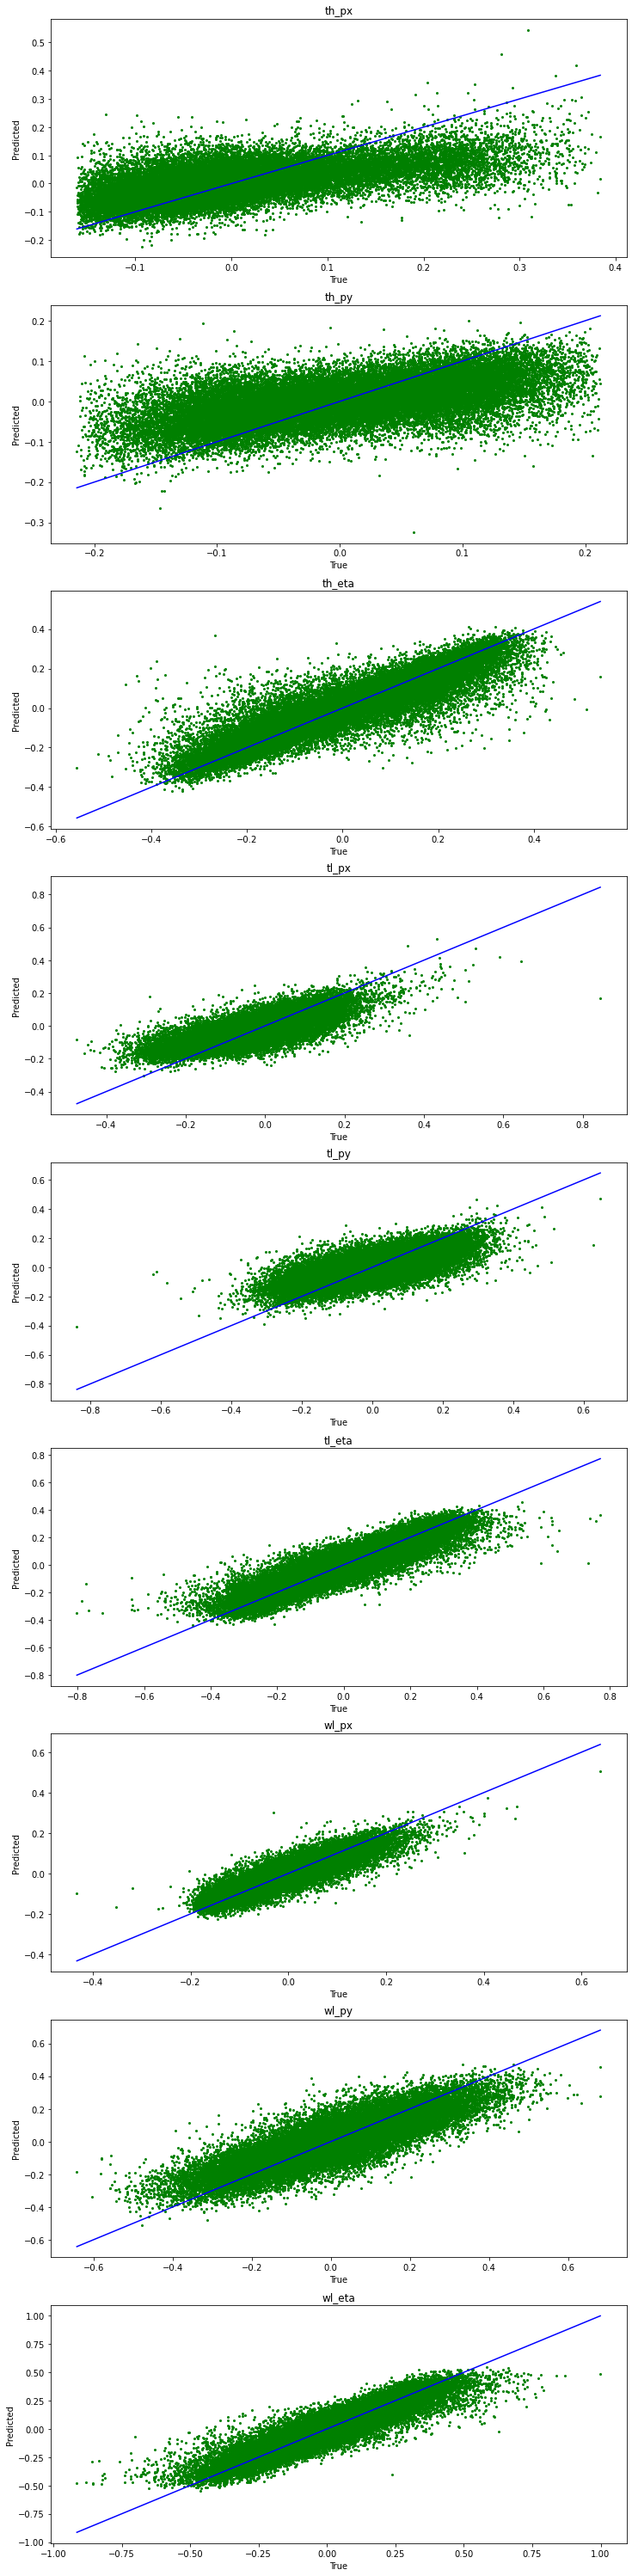

In [21]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [22]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 634.3315093791741
 
th_pt MSE :  2869.6294172238
th_eta MSE :  0.3609211905
th_phi MSE :  0.8025194780
tl_pt MSE :  2139.7791699305
tl_eta MSE :  0.3896606727
tl_phi MSE :  0.4924210169
wl_pt MSE :  691.1486300959
wl_eta MSE :  0.3357383832
wl_phi MSE :  0.2532344067


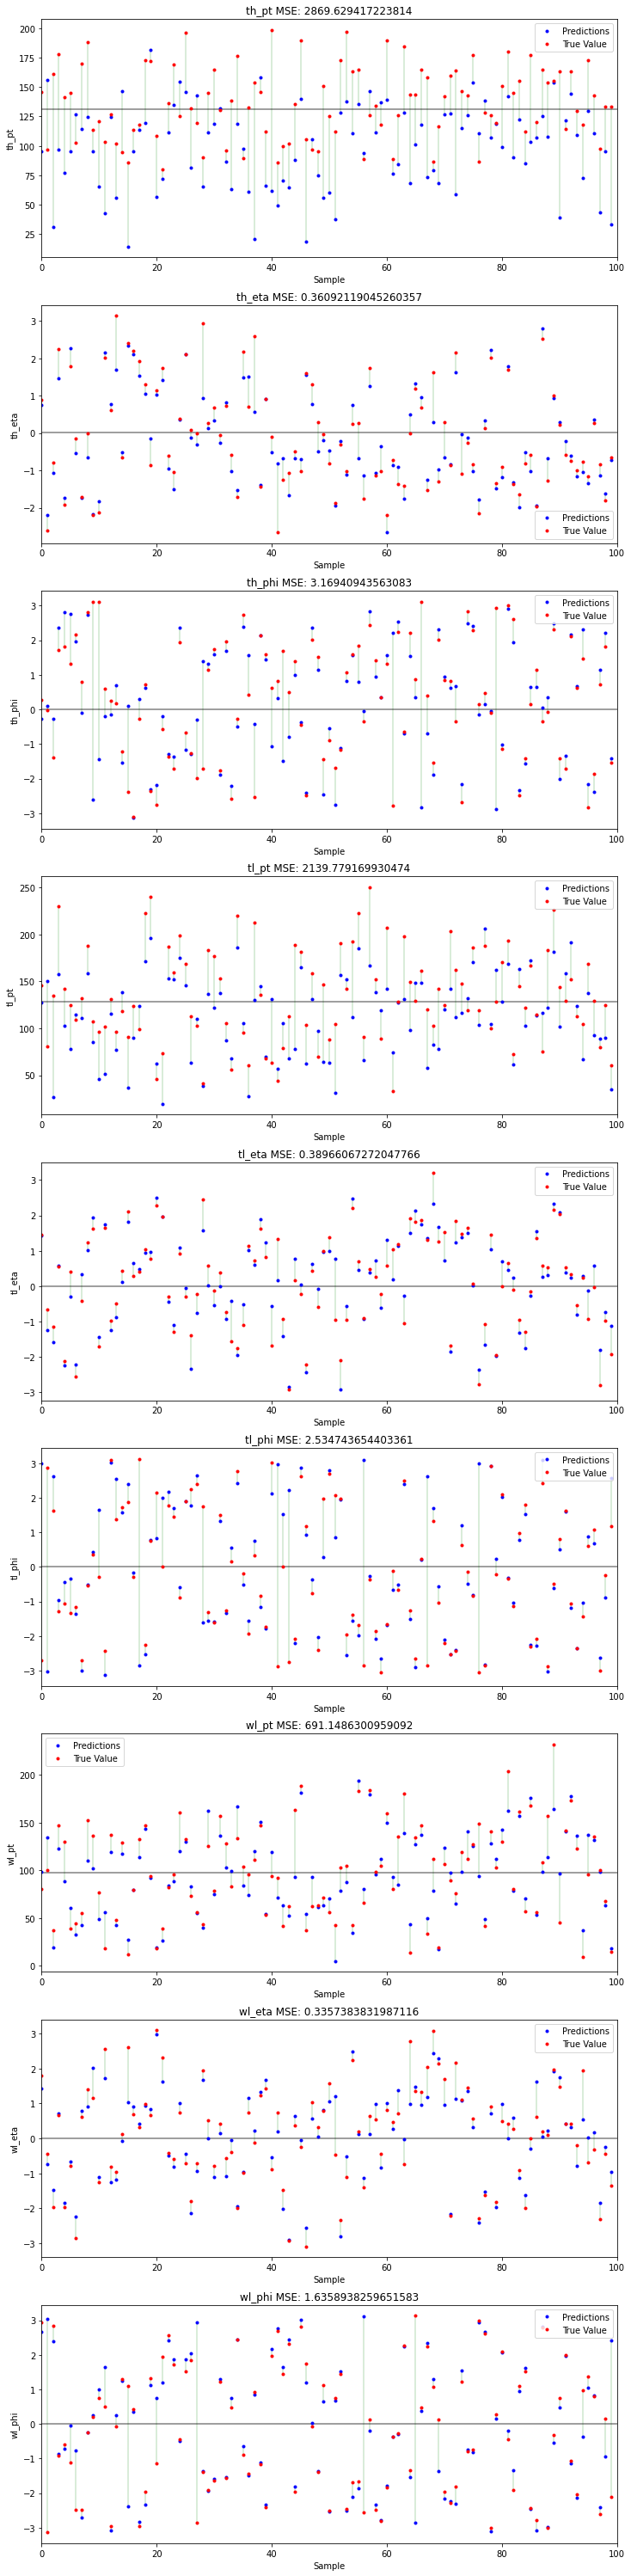

In [23]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

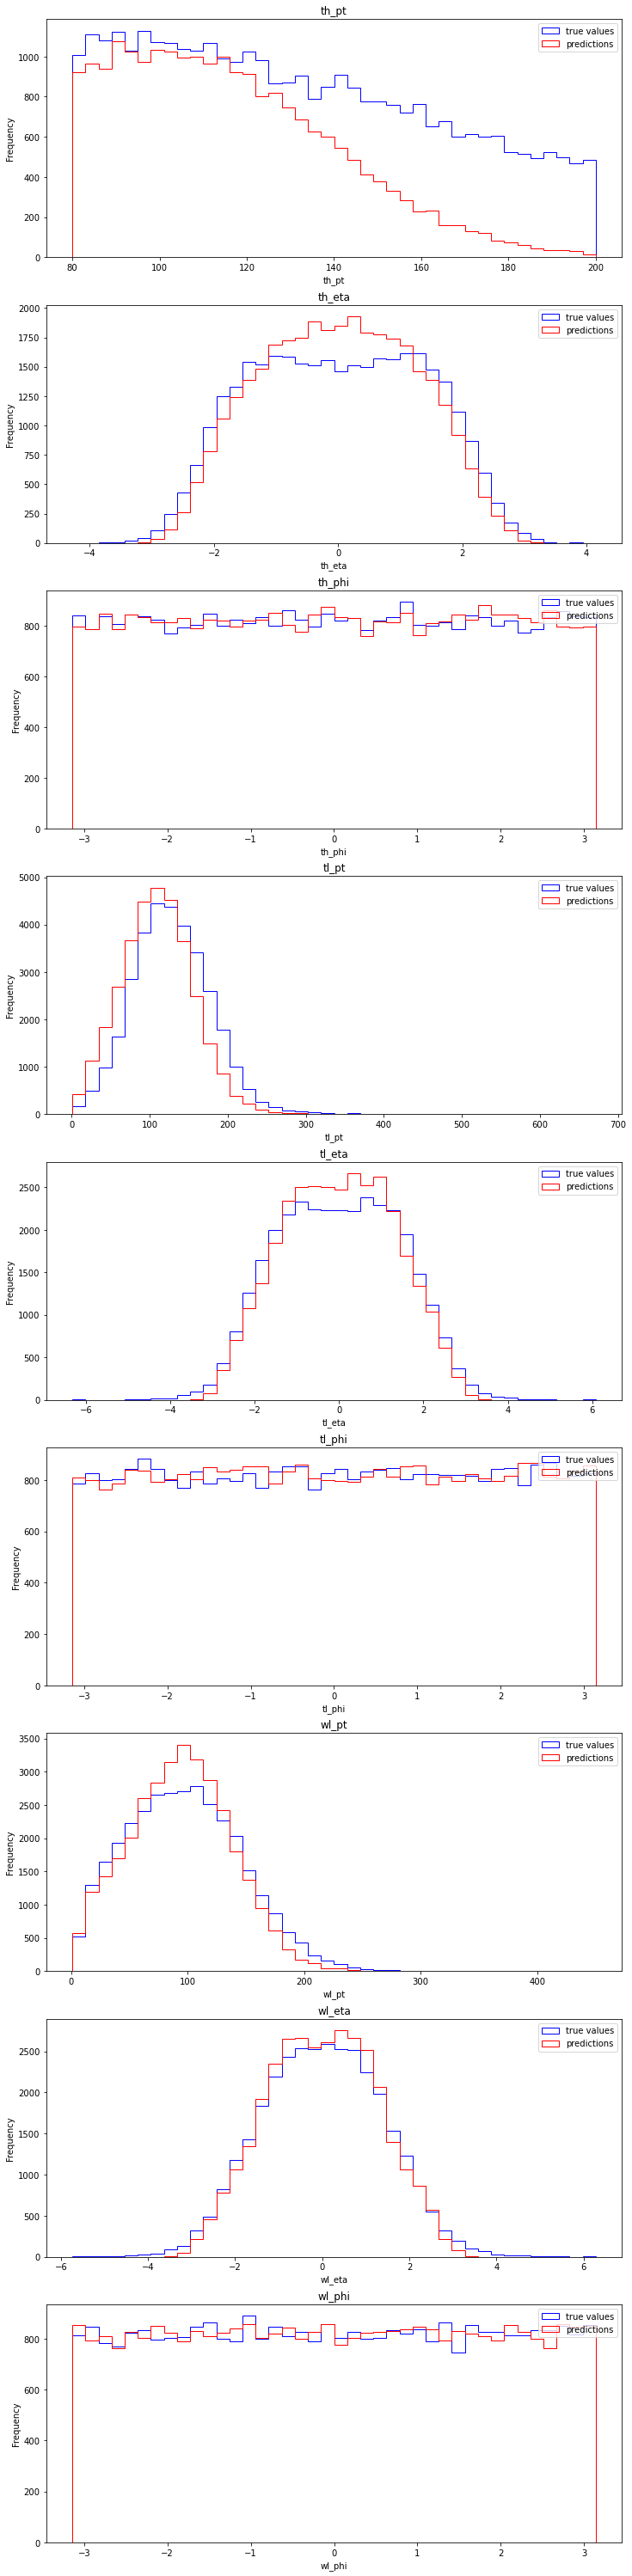

In [24]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

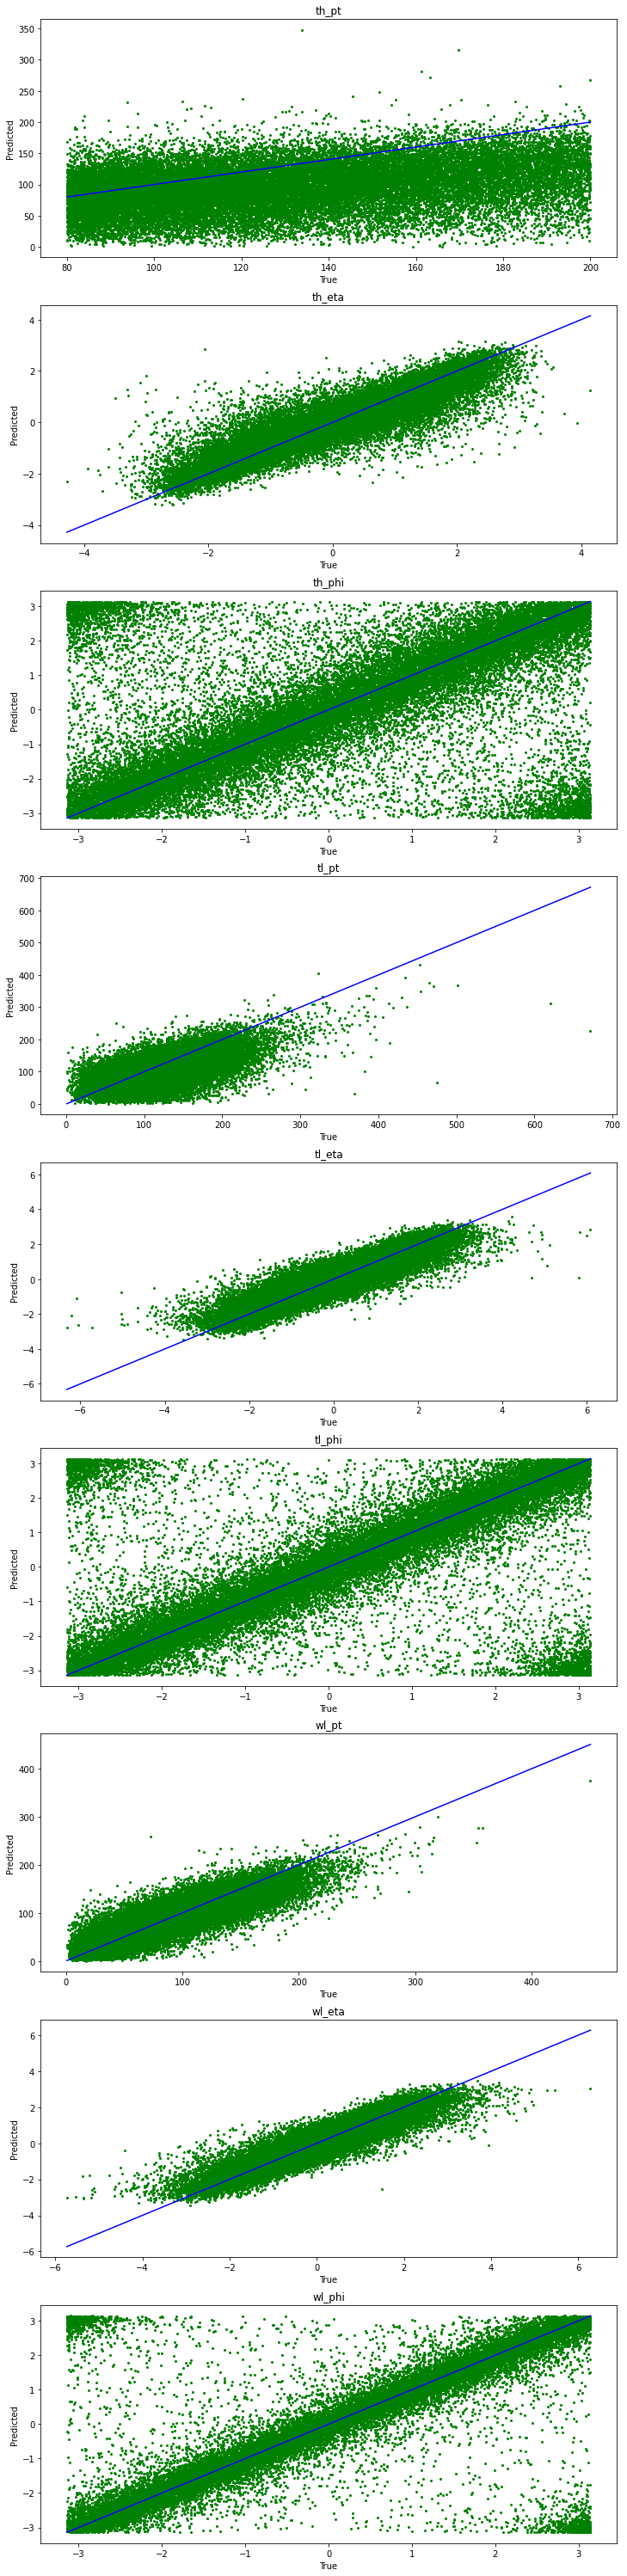

In [25]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)